In [1]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

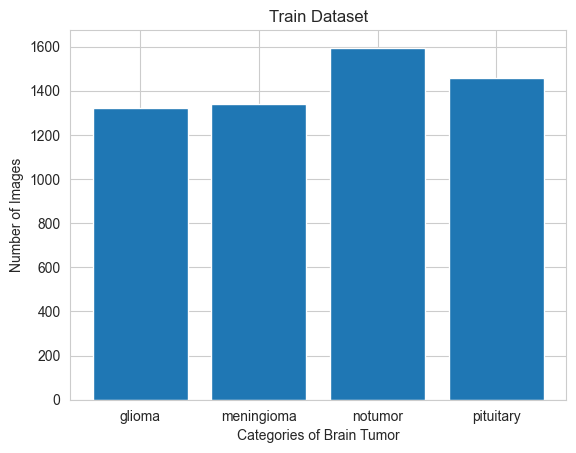

In [2]:
path1 = '/Brain tumor ml/dataset/Training'
subfolders1 = os.listdir(path1)
subfolder_counts1 = [len(os.listdir(os.path.join(path1, subfolder))) for subfolder in subfolders1]

x_labels = subfolders1
x = range(len(x_labels))
y = subfolder_counts1
plt.bar(x, y)

plt.xticks(x, x_labels)
plt.xlabel('Categories of Brain Tumor')
plt.ylabel('Number of Images')
plt.title('Train Dataset')

plt.show()

31


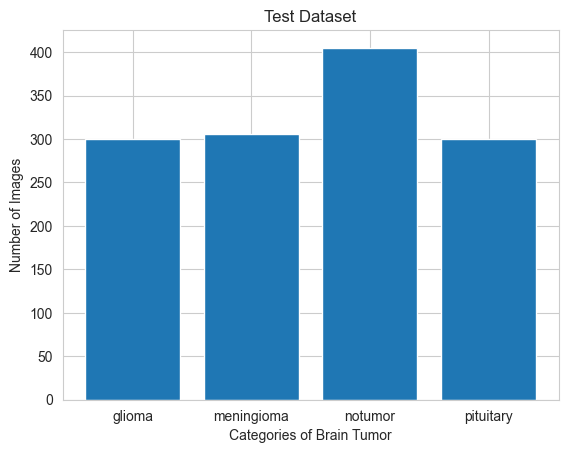

In [3]:
path2 = '/Brain tumor ml/dataset/Testing'
print(len(path2))
subfolders2 = os.listdir(path2)
subfolder_counts2 = [len(os.listdir(os.path.join(path2, subfolder))) for subfolder in subfolders2]

x_labels = subfolders2
x = range(len(x_labels))
y = subfolder_counts2
plt.bar(x, y)

plt.xticks(x, x_labels)
plt.xlabel('Categories of Brain Tumor')
plt.ylabel('Number of Images')
plt.title('Test Dataset')
plt.show()

In [4]:
# Paths to training and testing datasets

train_dir = '/Brain tumor ml/dataset/Training'

test_dir = '/Brain tumor ml/dataset/Testing'

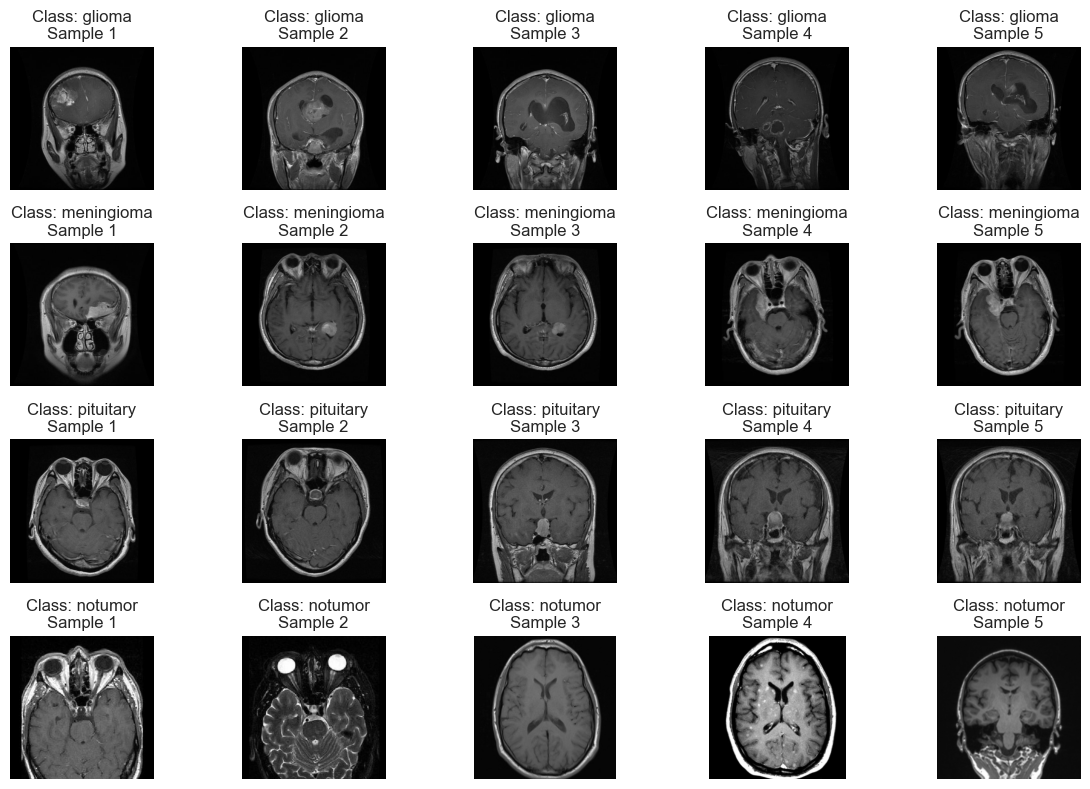

In [5]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# List of subdirectories representing different classes
class_folders = ['glioma', 'meningioma', 'pituitary', 'notumor']

plt.figure(figsize=(12, 8))

# Loop through each subdirectory and display sample images
for i, folder in enumerate(class_folders):
    sub_dir = os.path.join(train_dir, folder)
    sample_images = os.listdir(sub_dir)[:5]  # Load first 5 images from each subdirectory

    for j, image_name in enumerate(sample_images):
        img = Image.open(os.path.join(sub_dir, image_name))
        plt.subplot(4, 5, i * 5 + j + 1)
        plt.imshow(img)
        plt.title(f"Class: {folder}\nSample {j+1}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess training and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [8]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Define the model with InceptionV3 features
inception_model = Model(inputs=base_model.input, outputs=x)

In [9]:
train_features = inception_model.predict(train_generator)
test_features = inception_model.predict(test_generator)

41/41 [==============================] - 116s 3s/step


In [10]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Reshape

In [11]:
# Input layer for features
input_features = Input(shape=(2048,), name='input_features')

# Reshape features to match the expected input shape of the CNN model
reshaped_features = Reshape((32, 64, 1))(input_features)  # Adjust the dimensions based on your features

# CNN layers for feature extraction
cnn_output = Conv2D(32, (3, 3), activation='relu')(reshaped_features)
cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = Conv2D(32, (3, 3), activation='relu')(cnn_output)
cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = Conv2D(64, (3, 3), activation='relu')(cnn_output)
cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = Flatten()(cnn_output)

cnn_output_reshaped = Reshape((1, -1))(cnn_output)

bi_lstm_output = Bidirectional(LSTM(64, return_sequences=True))(cnn_output_reshaped)
bi_lstm_output = Bidirectional(LSTM(64, return_sequences=True))(bi_lstm_output)

# Flatten the output of Bi-LSTM
bi_lstm_output_flatten = Flatten()(bi_lstm_output)

dense_layer = Dense(128, activation='relu')(bi_lstm_output_flatten)
dense_layer = Dropout(0.5)(dense_layer)
dense_layer = Dense(64, activation='relu')(dense_layer)
output = Dense(4, activation='softmax')(dense_layer)

cnn_model = Model(inputs=input_features, outputs=output)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer  [(None, 2048)]            0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 32, 64, 1)         0         
                                                                 
 conv2d_94 (Conv2D)          (None, 30, 62, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 13, 29, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 14, 32)         0  

In [15]:
from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot encoding
train_labels_one_hot = to_categorical(train_generator.classes, num_classes=4)
test_labels_one_hot = to_categorical(test_generator.classes, num_classes=4)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [17]:
history_cnn = cnn_model.fit(
    train_features,
    train_labels_one_hot,
    validation_data=(test_features, test_labels_one_hot),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50

179/179 [==============================] - 34s 74ms/step - loss: 1.2328 - accuracy: 0.4100 - val_loss: 0.8646 - val_accuracy: 0.6133
Epoch 2/50
179/179 [==============================] - 9s 52ms/step - loss: 0.8025 - accuracy: 0.6756 - val_loss: 0.6857 - val_accuracy: 0.7178
Epoch 3/50
179/179 [==============================] - 8s 47ms/step - loss: 0.6032 - accuracy: 0.7659 - val_loss: 0.5748 - val_accuracy: 0.7735
Epoch 4/50
179/179 [==============================] - 8s 47ms/step - loss: 0.4750 - accuracy: 0.8192 - val_loss: 0.5933 - val_accuracy: 0.7773
Epoch 5/50
179/179 [==============================] - 8s 47ms/step - loss: 0.4038 - accuracy: 0.8543 - val_loss: 0.5651 - val_accuracy: 0.7681
Epoch 6/50
179/179 [==============================] - 9s 48ms/step - loss: 0.3268 - accuracy: 0.8859 - val_loss: 0.5686 - val_accuracy: 0.7986
Epoch 7/50
179/179 [==============================] - 17s 93ms/step - loss: 0.2640 - accuracy: 0.9121 - val_loss: 0.5587 - val_accuracy: 0.8

In [14]:
# save model and architecture to single file
cnn_model.save("cnn_model.h5")
print("Saved model to disk")

Saved model to disk


In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Conv2D, MaxPooling2D, Bidirectional, LSTM, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [19]:
# Define the input shape
input_features = Input(shape=(2048,), name='input_features')

# Reshape features to match the expected input shape of the CNN model
reshaped_features = Reshape((32, 64, 1))(input_features)  # Adjust the dimensions based on your features

# CNN layers for feature extraction
cnn_output = Conv2D(32, (3, 3), activation='relu')(reshaped_features)
cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = Conv2D(64, (3, 3), activation='relu')(cnn_output)
cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = Conv2D(128, (3, 3), activation='relu')(cnn_output)
cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = Flatten()(cnn_output)

cnn_output_reshaped = Reshape((1, -1))(cnn_output)

bi_lstm_output = Bidirectional(LSTM(128, return_sequences=True))(cnn_output_reshaped)
bi_lstm_output = Bidirectional(LSTM(64, return_sequences=True))(bi_lstm_output)

# Flatten the output of Bi-LSTM
bi_lstm_output_flatten = Flatten()(bi_lstm_output)

In [20]:
# Hyperparameters tuning
def build_model(hp):
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=32)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    batch_size = hp.Choice('batch_size', values=[16, 32, 64])
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=1e-3)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=1e-3)
    else:
        optimizer = SGD(learning_rate=1e-3)
    dense_layer = Dense(dense_units, activation='relu')(bi_lstm_output_flatten)
    dense_layer = Dropout(dropout_rate)(dense_layer)
    dense_layer = Dense(64, activation='relu')(dense_layer)
    output = Dense(4, activation='softmax')(dense_layer)

    cnn_model = Model(inputs=input_features, outputs=output)
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return cnn_model

In [21]:
# Create tuner and perform hyperparameter
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='hyperparameter_tuning',
    project_name='cnn_model_tuning'
)

# Assuming you already have train_features, test_features, train_labels_one_hot, and test_labels_one_hot
tuner.search(
    train_features, 
    train_labels_one_hot, 
    epochs=50,
    validation_data=(test_features, test_labels_one_hot),
    callbacks=[early_stopping]
)

Trial 10 Complete [00h 03m 41s]
val_accuracy: 0.8405796885490417

Best val_accuracy So Far: 0.8489702343940735
Total elapsed time: 00h 24m 55s


Hyperparameter search

In [30]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape, Conv2D, MaxPooling2D, Flatten, Dense, Bidirectional, GRU, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt

In [31]:
from tensorflow.keras.regularizers import l2

# Define your model architecture
def build_model(hp):
    model = Sequential()

    input_features = Input(shape=(2048,), name='input_features')
    reshaped_features = Reshape((32, 64, 1))(input_features)

    # CNN layers for feature extraction
    cnn_output = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(hp.Float('kernel_regularizer', min_value=1e-5, max_value=1e-2, sampling='log')))(reshaped_features)
    cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
    cnn_output = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(hp.Float('kernel_regularizer', min_value=1e-5, max_value=1e-2, sampling='log')))(cnn_output)
    cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
    cnn_output = Flatten()(cnn_output)

    cnn_output_reshaped = Reshape((1, -1))(cnn_output)

    # Bi-GRU layers with dropout
    for _ in range(hp.Int('num_bigru_layers', min_value=1, max_value=3, step=1)):
        model.add(Bidirectional(GRU(units=hp.Int('bigru_units', min_value=32, max_value=128, step=32),
                                     return_sequences=True, dropout=hp.Float('bigru_dropout', min_value=0.2, max_value=0.5, step=0.1))))
        model.add(Dropout(hp.Float('bigru_dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Flatten the output of Bi-GRU
    bi_gru_output_flatten = Flatten()(cnn_output_reshaped)

    dense_layer = Dense(128, activation='relu', kernel_regularizer=l2(hp.Float('kernel_regularizer', min_value=1e-5, max_value=1e-2, sampling='log')))(bi_gru_output_flatten)
    dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(hp.Float('kernel_regularizer', min_value=1e-5, max_value=1e-2, sampling='log')))(dense_layer)
    output = Dense(4, activation='softmax')(dense_layer)

    model = Model(inputs=input_features, outputs=output)

    # Choose an optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=1e-3)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=1e-3)
    else:
        optimizer = SGD(learning_rate=1e-3)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [32]:
# Create tuner and perform hyperparameter search
tuner_ = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='hyperparameter_tuning',
    project_name='optimizer_layers'
)

tuner_.search(train_features, train_labels_one_hot,batch_size=32, epochs=10, validation_data=(test_features, test_labels_one_hot))

Trial 10 Complete [00h 01m 11s]
val_accuracy: 0.8611747026443481

Best val_accuracy So Far: 0.8634629845619202
Total elapsed time: 00h 10m 50s
